In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

Let's try to apply the DLT.

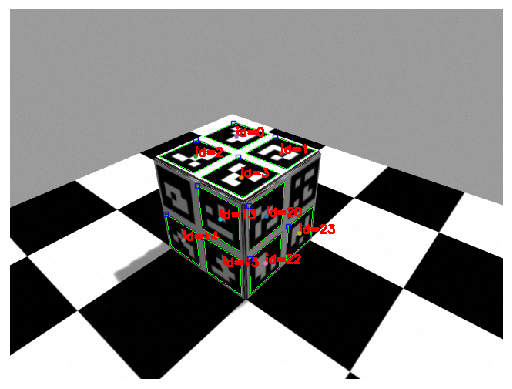

array([20,  3,  2,  1,  0, 15, 22, 14, 23, 13], dtype=int32)

In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path
import numpy as np

from camera import (
    move_camera_pos,
    get_camera_image_rgb,
    get_camera_image_depth,
    draw_aruco_grid,
    extract_aruco_tags,
    draw_aruco_tags,
    map_id_to_world_coords,
)
import rospy

rospy.init_node("camera_test")
move_camera_pos(-0.4, -0.4, 1, pitch=0.6, yaw=0.7)
rgb = get_camera_image_rgb()
frame_markers, corners, ids = extract_aruco_tags(rgb)
draw_aruco_tags(frame_markers, corners, ids)
plt.show()
ids = ids.reshape(-1)
ids

In [15]:
corner_means = []
for i in range(len(ids)):
    c = corners[i][0]
    corner_means.append([c[:, 0].mean(), c[:, 1].mean()])
corner_means = np.array(corner_means)
corner_means

array([[332.25, 267.75],
       [299.  , 216.75],
       [240.25, 190.  ],
       [351.25, 185.75],
       [293.25, 164.25],
       [276.25, 333.  ],
       [331.  , 329.25],
       [224.5 , 299.  ],
       [375.25, 290.5 ],
       [271.75, 271.25]], dtype=float32)

In [23]:
corner_means = np.array(corners).squeeze(1).mean(axis=1)
corner_means

array([[332.25, 267.75],
       [299.  , 216.75],
       [240.25, 190.  ],
       [351.25, 185.75],
       [293.25, 164.25],
       [276.25, 333.  ],
       [331.  , 329.25],
       [224.5 , 299.  ],
       [375.25, 290.5 ],
       [271.75, 271.25]], dtype=float32)

In [8]:
mapping = map_id_to_world_coords()
mapping[ids]

array([[ 0.026875,  0.1     ,  0.076875],
       [ 0.026875,  0.026875,  0.1     ],
       [ 0.026875, -0.025625,  0.1     ],
       [-0.025625,  0.026875,  0.1     ],
       [-0.025625, -0.025625,  0.1     ],
       [ 0.1     , -0.025625,  0.024375],
       [ 0.026875,  0.1     ,  0.024375],
       [ 0.1     ,  0.026875,  0.024375],
       [-0.025625,  0.1     ,  0.024375],
       [ 0.1     , -0.025625,  0.076875]])

- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf

In [45]:
from camera import compute_dlt

P = compute_dlt(mapping[ids], corner_means)
P

array([[-1.75977584e+03, -1.75679716e+03, -3.67719374e+03,
         3.23771369e+02],
       [-1.41958429e+03, -1.48449349e+03, -3.10316888e+03,
         2.76087482e+02],
       [-5.35832656e+00, -5.46791800e+00, -1.14830536e+01,
         1.00000000e+00]])

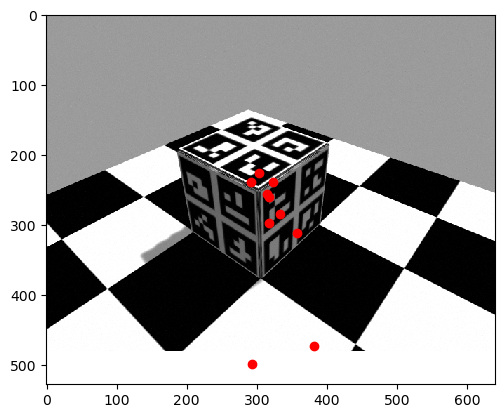

In [46]:
# let's reproject the points and see if they are close to the original ones

Z = P @ np.vstack([mapping[ids].T, np.ones(len(ids))])
Z = Z / Z[2, :]
Z = Z.T
plt.imshow(rgb)
plt.scatter(Z[:, 0], Z[:, 1], c="r")
plt.show()